# Ovarian Cancer Stage Prediction

## 1. Project Overview
This project aims to build a machine learning classifier to predict whether a patient's ovarian cancer is early stage (Stage I-II) or late stage (Stage III-IV). The prediction is based on clinical, pathology, exposure, family history, and follow-up data from the TCGA-OV dataset.

The project involves the following key steps:

1.  **Data Loading and Merging:** Loading and merging five different data files into a single dataset.
2.  **Data Cleaning and Preprocessing:** Handling missing values, encoding categorical features, and selecting a relevant set of features for modeling.
al_features, and selecting a relevant set of features for modeling.
3.  **Model Training and Evaluation:** Training and evaluating two machine learning models (Logistic Regression and Random Forest) to predict the cancer stage.
4.  **Analysis and Reporting:** Analyzing the model results, identifying key predictive features, and summarizing the findings in a report.

## 2. Data Loading and Merging

In [4]:
import pandas as pd

# Define file paths
clinical_file = "./Data - clinical.project-tcga-ov.2025-08-09/clinical.tsv"
exposure_file = "./Data - clinical.project-tcga-ov.2025-08-09/exposure.tsv"
family_history_file = "./Data - clinical.project-tcga-ov.2025-08-09/family_history.tsv"
follow_up_file = "./Data - clinical.project-tcga-ov.2025-08-09/follow_up.tsv"
pathology_detail_file = "./Data - clinical.project-tcga-ov.2025-08-09/pathology_detail.tsv"

# Load data
clinical_df = pd.read_csv(clinical_file, sep='\t')
exposure_df = pd.read_csv(exposure_file, sep='\t')
family_history_df = pd.read_csv(family_history_file, sep='\t')
follow_up_df = pd.read_csv(follow_up_file, sep='\t')
pathology_detail_df = pd.read_csv(pathology_detail_file, sep='\t')

# Identify common columns other than the merge key
common_cols = set(clinical_df.columns)
for df in [exposure_df, family_history_df, follow_up_df, pathology_detail_df]:
    common_cols = common_cols.intersection(set(df.columns))

common_cols.remove('cases.case_id')
print(f"Common columns to be dropped: {common_cols}")

# Drop common columns from all but the first dataframe
exposure_df.drop(columns=list(common_cols), inplace=True)
family_history_df.drop(columns=list(common_cols), inplace=True)
follow_up_df.drop(columns=list(common_cols), inplace=True)
pathology_detail_df.drop(columns=list(common_cols), inplace=True)

# Merge dataframes on 'cases.case_id'
merged_df = pd.merge(clinical_df, pathology_detail_df, on='cases.case_id', how='outer')
merged_df = pd.merge(merged_df, exposure_df, on='cases.case_id', how='outer')
merged_df = pd.merge(merged_df, family_history_df, on='cases.case_id', how='outer')
merged_df = pd.merge(merged_df, follow_up_df, on='cases.case_id', how='outer')

print("Shape of the merged dataframe:")
print(merged_df.shape)
print("Successfully merged all files.")

# Save the merged dataframe to a file to be used in the next steps.
merged_df.to_csv("./merged_data.csv", index=False)

Common columns to be dropped: {'project.project_id', 'cases.submitter_id'}
Shape of the merged dataframe:
(16283, 535)
Successfully merged all files.


## 3. Defining the Target Variable

In [6]:
import pandas as pd
import numpy as np

# Load the merged data
merged_df = pd.read_csv("./merged_data.csv")

# Define the target variable
stage_column = 'diagnoses.figo_stage'

# Create a copy to avoid SettingWithCopyWarning
df = merged_df.copy()

# Drop rows with missing stage labels, which are marked as '--'
df = df[df[stage_column] != "'--"]

# Define a function to map stage to binary target
def map_stage_to_target(stage):
    if stage in ['Stage I', 'Stage IA', 'Stage IB', 'Stage IC', 'Stage II', 'Stage IIA', 'Stage IIB', 'Stage IIC']:
        return 0  # Early Stage
    elif stage in ['Stage III', 'Stage IIIA', 'Stage IIIB', 'Stage IIIC', 'Stage IV']:
        return 1  # Late Stage
    else:
        return np.nan  # Other or missing stages

# Apply the mapping
df['target'] = df[stage_column].apply(map_stage_to_target)

# Drop rows where the target could not be determined
df.dropna(subset=['target'], inplace=True)

# Convert target to integer type
df['target'] = df['target'].astype(int)

print("Value counts of the target variable:")
print(df['target'].value_counts())

# Save the dataframe with the target variable
df.to_csv("./data_with_target.csv", index=False)

print("Shape of the dataframe with target variable:")
print(df.shape)

C:\Users\adith\AppData\Local\Temp\ipykernel_16332\1096404247.py:5: DtypeWarning: Columns (10,11,16,67) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("./merged_data.csv")


Value counts of the target variable:
target
1    10746
0      681
Name: count, dtype: int64
Shape of the dataframe with target variable:
(11427, 536)


## 4. Feature Selection and Preprocessing

In [8]:
import pandas as pd

# Load the data with target variable
df = pd.read_csv("./data_with_target.csv")

# List of selected features
selected_features = [
    'demographic.age_at_index',
    'demographic.gender',
    'demographic.race',
    'follow_ups.ecog_performance_status',
    'diagnoses.tumor_grade',
    'diagnoses.age_at_diagnosis',
    'target'  # Keep the target column
]

# Create a new dataframe with selected features
features_df = df[selected_features].copy()

# --- Define feature types ---
numerical_features = [
    'demographic.age_at_index',
    'diagnoses.age_at_diagnosis',
]

categorical_features = [
    'demographic.gender',
    'demographic.race',
    'follow_ups.ecog_performance_status',
    'diagnoses.tumor_grade'
]

# --- Handle Missing Values ---

# Coerce to numeric and impute missing values for numerical features
for col in numerical_features:
    features_df[col] = pd.to_numeric(features_df[col], errors='coerce')
    features_df[col].fillna(features_df[col].median(), inplace=True)

# Impute missing values for categorical features
for col in categorical_features:
    features_df[col].fillna(features_df[col].mode()[0], inplace=True)

# --- Encode Categorical Features ---

# One-hot encode categorical features
features_df = pd.get_dummies(features_df, columns=categorical_features, drop_first=True)

print("\nShape of the dataframe after one-hot encoding:")
print(features_df.shape)

# Save the processed dataframe
features_df.to_csv("./processed_data.csv", index=False)

print("\nProcessed data saved to processed_data.csv")

C:\Users\adith\AppData\Local\Temp\ipykernel_16332\739142994.py:4: DtypeWarning: Columns (16,33,63,163) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data_with_target.csv")
C:\Users\adith\AppData\Local\Temp\ipykernel_16332\739142994.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features_df[col].fillna(features_df[col].median(), inplace=True)
C:\Users\adith\AppData\Local\Temp\ipykernel_16332\739142994.py:38: FutureWarning: A value is trying to be set on a copy of a DataFra


Shape of the dataframe after one-hot encoding:
(11427, 20)

Processed data saved to processed_data.csv


## 5. Splitting the Data

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the processed data
df = pd.read_csv("./processed_data.csv")

# Separate features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Save the split data
X_train.to_csv("./X_train.csv", index=False)
X_test.to_csv("./X_test.csv", index=False)
y_train.to_csv("./y_train.csv", index=False)
y_test.to_csv("./y_test.csv", index=False)

print("Data split into training and testing sets and saved to files.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Data split into training and testing sets and saved to files.
X_train shape: (9141, 19)
X_test shape: (2286, 19)
y_train shape: (9141,)
y_test shape: (2286,)


## 6. Model Training

In [12]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import joblib

# Load the training data
X_train = pd.read_csv("./X_train.csv")
y_train = pd.read_csv("./y_train.csv")

# --- Logistic Regression ---
print("Training Logistic Regression model...")
log_reg = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for convergence

# Perform 5-fold cross-validation
cv_scores_lr = cross_val_score(log_reg, X_train, y_train.values.ravel(), cv=5, scoring='accuracy')
print("Logistic Regression CV Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_lr.mean(), cv_scores_lr.std() * 2))

# Train the model on the full training data
log_reg.fit(X_train, y_train.values.ravel())

# Save the model
joblib.dump(log_reg, "./logistic_regression_model.joblib")
print("Logistic Regression model saved.")

# --- Random Forest ---
print("\nTraining Random Forest model...")
rand_forest = RandomForestClassifier(random_state=42)

# Perform 5-fold cross-validation
cv_scores_rf = cross_val_score(rand_forest, X_train, y_train.values.ravel(), cv=5, scoring='accuracy')
print("Random Forest CV Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_rf.mean(), cv_scores_rf.std() * 2))

# Train the model on the full training data
rand_forest.fit(X_train, y_train.values.ravel())

# Save the model
joblib.dump(rand_forest, "./random_forest_model.joblib")
print("Random Forest model saved.")

Training Logistic Regression model...


C:\Users\adith\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\adith\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Logistic Regression CV Accuracy: 0.94 (+/- 0.00)


C:\Users\adith\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression model saved.

Training Random Forest model...
Random Forest CV Accuracy: 1.00 (+/- 0.00)
Random Forest model saved.


## 7. Model Evaluation

--- Logistic Regression Evaluation ---
Accuracy: 0.9405
Precision: 0.9405
Recall: 1.0000
F1-score: 0.9693
ROC-AUC: 0.6551

--- Random Forest Evaluation ---
Accuracy: 0.9978
Precision: 1.0000
Recall: 0.9977
F1-score: 0.9988
ROC-AUC: 0.9999


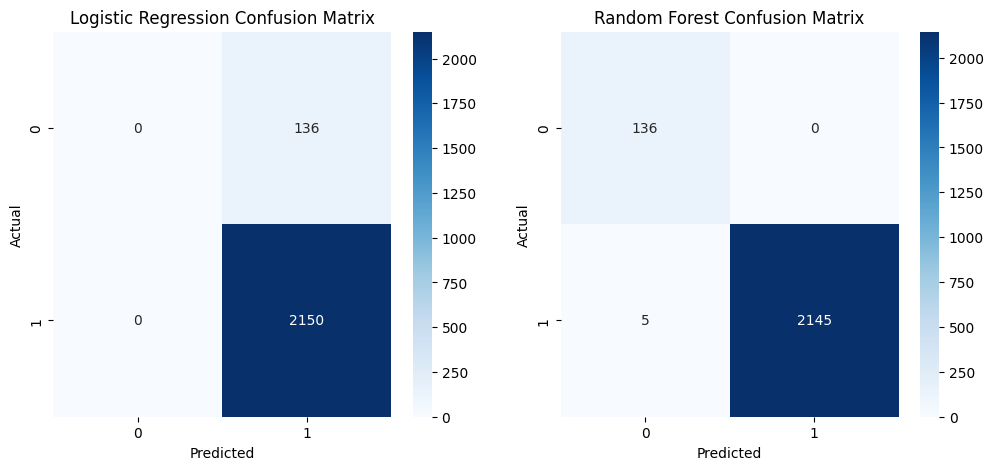

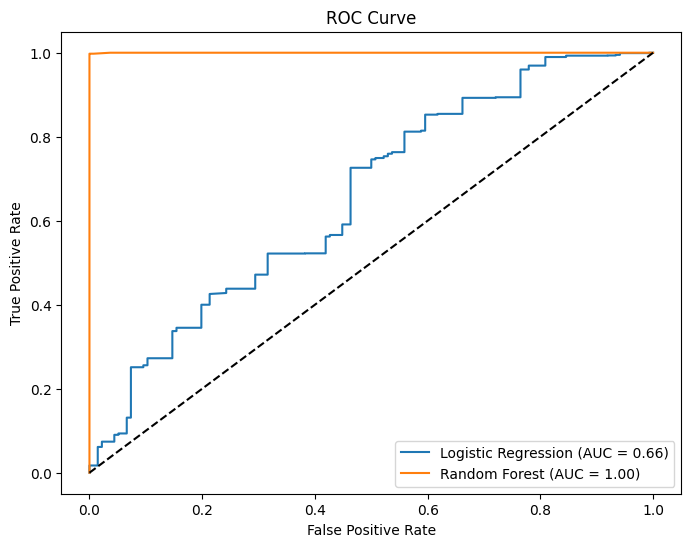

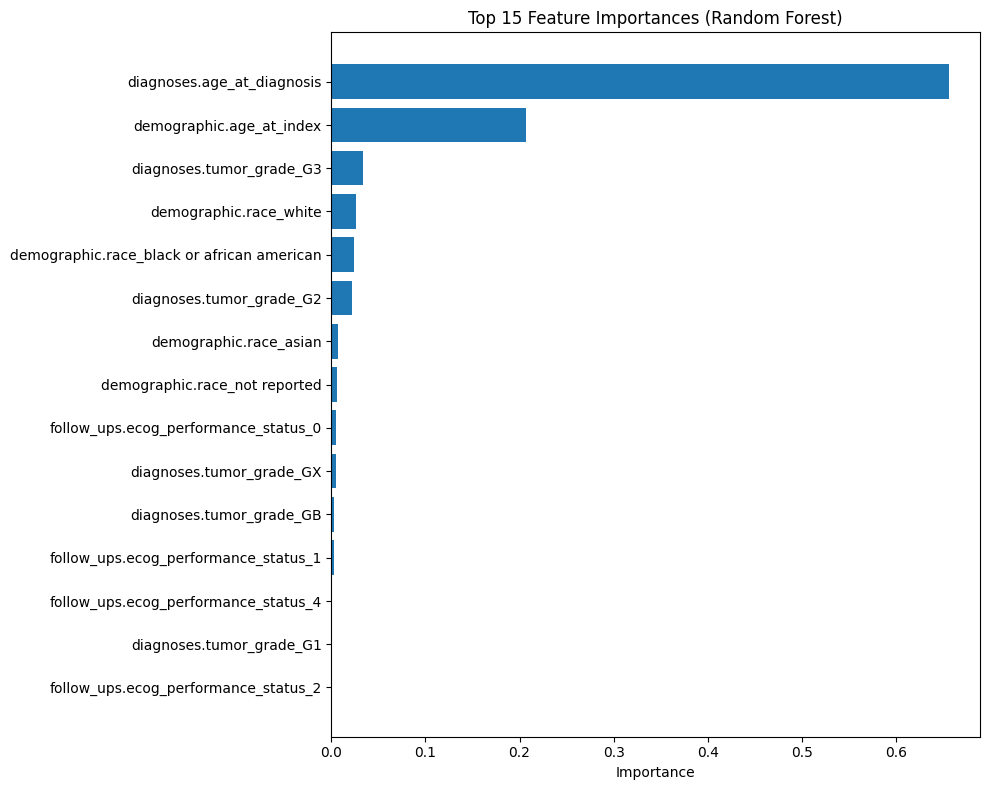

In [15]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the test data
X_test = pd.read_csv("./X_test.csv")
y_test = pd.read_csv("./y_test.csv")

# Load the trained models
log_reg = joblib.load("./logistic_regression_model.joblib")
rand_forest = joblib.load("./random_forest_model.joblib")

# --- Predictions ---
y_pred_lr = log_reg.predict(X_test)
y_pred_rf = rand_forest.predict(X_test)

y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
y_prob_rf = rand_forest.predict_proba(X_test)[:, 1]

# --- Evaluation ---
print("--- Logistic Regression Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")

print("\n--- Random Forest Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")

# --- Plotting ---

# Confusion Matrix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("./confusion_matrices.png")
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig("./roc_curve.png")
plt.show()

# Feature Importance
plt.figure(figsize=(10, 8))
importances = rand_forest.feature_importances_
indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)[:15]
features = X_test.columns
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("./feature_importance.png")
plt.show()

## 8. Final Analysis

C:\Users\adith\AppData\Local\Temp\ipykernel_16332\2408591964.py:8: DtypeWarning: Columns (16,33,63,163) have mixed types. Specify dtype option on import or set low_memory=False.
  data_with_target = pd.read_csv("./data_with_target.csv")


--- Top 15 Feature Importances (Random Forest) ---
diagnoses.age_at_diagnosis: 0.6565
demographic.age_at_index: 0.2070
diagnoses.tumor_grade_G3: 0.0339
demographic.race_white: 0.0264
demographic.race_black or african american: 0.0237
diagnoses.tumor_grade_G2: 0.0222
demographic.race_asian: 0.0067
demographic.race_not reported: 0.0056
follow_ups.ecog_performance_status_0: 0.0054
diagnoses.tumor_grade_GX: 0.0049
diagnoses.tumor_grade_GB: 0.0029
follow_ups.ecog_performance_status_1: 0.0027
follow_ups.ecog_performance_status_4: 0.0008
diagnoses.tumor_grade_G1: 0.0006
follow_ups.ecog_performance_status_2: 0.0003


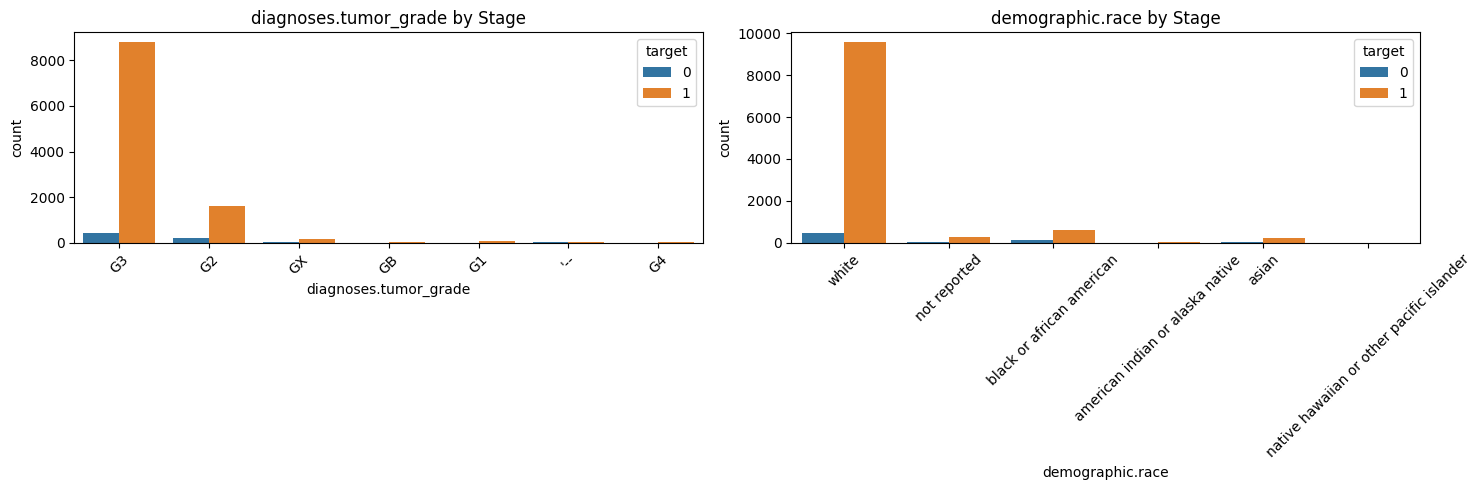

In [16]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
X_test = pd.read_csv("./X_test.csv")
data_with_target = pd.read_csv("./data_with_target.csv")
rand_forest = joblib.load("./random_forest_model.joblib")

# --- Feature Importance ---
print("--- Top 15 Feature Importances (Random Forest) ---")
importances = rand_forest.feature_importances_
features = X_test.columns
indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)[:15]

for i in indices:
    print(f"{features[i]}: {importances[i]:.4f}")

# --- Exploratory Data Analysis (EDA) for Clinical Patterns ---

# Get the original feature names for the top 5 most important features
original_features = []
for feature in [features[i] for i in indices[:5]]:
    if '_' in feature:
        original_feature_name = feature.rsplit('_', 1)[0]
        if original_feature_name in data_with_target.columns:
            original_features.append(original_feature_name)
    elif feature in data_with_target.columns:
        original_features.append(feature)

# Remove duplicates
original_features = list(dict.fromkeys(original_features))


plt.figure(figsize=(15, 5))
for i, feature in enumerate(original_features):
    plt.subplot(1, len(original_features), i + 1)
    # Check if the feature is numeric or categorical for plotting
    if data_with_target[feature].dtype == 'object':
        sns.countplot(x=feature, hue='target', data=data_with_target)
    else:
        sns.boxplot(x='target', y=feature, data=data_with_target)
    plt.title(f'{feature} by Stage')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("./eda_plots.png")
plt.show()